# Transfer Learning On Oxford 102 Flowers Dataset With Mobilenet Large and Small Weightsgnment. 

In this file we will explore the use and effectiveness of transfer learning using both small and large mobilenet v3 on the Oxford 102 dataset (https://www.robots.ox.ac.uk/~vgg/data/flowers/102/ using downloads 1 - data and 4 - labels).

Taking a closer look at dataset, we see that it has 102 classes and aroud 8189 training images.

The dataset is large enough to train a smaller model from scratch but only with many epochs. In the cases where we don't have large enough data, using transfer learning can be a great option. Let's see how well mobilenet v3 model performs on this dataset.

We will experiment trying to use 5, 10, 20, 30, and 40 training images for each class (amounting to a total of 510, 1020, 2040, 3060, and 4080 training images), leaving 4109 images for testing.

Note that this was run in the anaconda environment environment.yml included in the submission of this assignment. 

We begin by loading the necessary imports

Note: IDK why the text in the cell above isnt rendering correctly... inspect a cell if it is not making sense as the text there is correct.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision.io import read_image
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io # used to load mat files

Enable GPU usage

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Since we will be using multiple versions of mobilenet (large, small, and pretrained vs not pretrained - for comparison and analysis) we implement a functoin to load the correct model and return it.

In [4]:
# https://pytorch.org/vision/stable/models/mobilenetv3.html
# https://pytorch.org/blog/torchvision-mobilenet-v3-implementation/
def get_cleared_model(num_classes = 12, model_type = "large"):
    """
    returns the mobilenet v3 model of type model_type (one of large, small, or small_blank), and modifies it so that the final output layer
    has size num_classes. 
    Returns the selected model or nothing no valid model is selected
    """
    if model_type == "large":
        large_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
        num_features = large_model.classifier[-1].in_features
        large_model.classifier[-1] = nn.Linear(num_features, num_classes)
        return large_model
    elif model_type == "small":
        small_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
        num_features = small_model.classifier[-1].in_features
        small_model.classifier[-1] = nn.Linear(num_features, num_classes)
        return small_model
    elif model_type == "small_blank":
        small_model = mobilenet_v3_small()
        num_features = small_model.classifier[0].in_features
        small_model.classifier = nn.Linear(num_features, num_classes)
        return small_model

    return None

Next we will establish the data transform to apply to our images to have them fit the input of the mobile net v3 models

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),   # Convert to PIL Image
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.ToTensor()                # Convert to PyTorch tensor
])

Now we create a function to load the data that makes the correct train/test split to ensure that reguardless of the amount of data in the train section, the test data will remain the same for consistency of analysis. We make this function since we will load a new train/test split many times to see how the amount of training data impacts the performance of the transfer learning.

In [6]:
def load_dataset(dataset_path="data/Oxford_102/", training_amount = 20, max_training_amount = 40, num_classes = 102):
    """
    load_dataset returns X_train, X_test, y_train, y_test of the Oxford 102 dataset found at the path dataset_path
    The dataset must follow a specific form that can be viewed in this directory, if it is deviated from changes may have to be made.
    Since we create our own train/test split we expect there to be one set of labels and one file of images that correspond. 
    training_amount is the amount of data we will want to be in the training set
    max_training_amount is the max amount of training data we will use at all in the program (necessary to ensure test dataset is the same for all train splits
    num_classes is the number of classes of the dataset (102 for oxford flowers)
    """
    X_train = []
    X_test = []
    label_train = []
    label_test = []
    label_train_amount = [training_amount] * num_classes     # will keep track of how many training examples are left for each label
    label_test_amount = [max_training_amount] * num_classes     # will keep track of how many examples we still must get through before getting to the training data for each label

    data_file_path = dataset_path + "102flowers/jpg" # set path for reading the images

    label_file_path = dataset_path + 'imagelabels.mat'

    # read and properly shape/index the labels
    labels = scipy.io.loadmat(label_file_path)['labels'] # read the labels
    labels -= 1
    labels = torch.from_numpy(labels).flatten()

    # load the images one by one and put into the correct set of train/test/ignore
    for ind, image_file in enumerate(os.listdir(data_file_path)):
        image_path = os.path.join(data_file_path, image_file)
        im = read_image(image_path)
        label = labels[ind]
        if im is not None:
            # shape the images to be consistent shape
            im = F.interpolate(im.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
            im = im.squeeze(0)

            # classify as train/test/ignore
            if label_train_amount[label] > 0:
                label_train_amount[label] -= 1
                label_test_amount[label] -= 1
                X_train.append(im)
                label_train.append(label)
            elif label_test_amount[label] > 0:
                label_test_amount[label] -= 1
            else:
                X_test.append(im)
                label_test.append(label)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    label_train = np.array(label_train)
    label_test = np.array(label_test)

    return X_train.transpose((0, 2, 3, 1)), X_test.transpose((0, 2, 3, 1)), label_train, label_test

Now we create a train function to run one epoch of training, which allows us more flexibility to store results as desired later.

In [7]:
def train(model, train_loader, criterion = nn.CrossEntropyLoss()):
    """
    trains model on train_loader using criterion as the loss function and Adam optimizer
    returns the loss and accuracy of the epoch
    """
    # initializations
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    size = len(train_loader.dataset)
    num_batches = len(train_loader)
    
    # train the model
    model.train()
    total_loss = 0.0
    correct = 0.0
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.long)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # loss and accuracy tracking
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
                
    return total_loss/num_batches, correct/size

Create a test function

In [8]:
def test(model, test_loader, criterion = nn.CrossEntropyLoss()):
    """
    tests model on test_loader using criterion loss
    returns the loss and accuracy
    """
    # initializations
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    total_loss, correct = 0.0, 0.0

    # test
    with torch.no_grad():  # for testing not training
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = y.to(torch.long)
            total_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return total_loss/num_batches, correct/size

Write a function to run a train test sequence that we can apply to each of the model types

In [9]:
def train_test_sequence(model_name = "large", save_base_name = None, train_size = [5, 10, 20, 30, 40], epochs = 15, num_classes = 102, dataset_path = 'data/Oxford_102/'):
    """
    model_name -> the model name provided to get_cleared_model. One of large, small, small_blank
    save_base_name -> path to save the model state in
    train_size -> a list of the size of the training set for each class we will run a train/test sequence on
    epochs -> the number of epochs used for each set
    num_classes -> the number of classes in the dataset being used (102 for Oxford Flowers)
    dataset_path -> the path to the Oxford 102 data

    Returns: a 2D list where each row is the train accuracy for each entry of train_size and the column is the performance at that epoch
            and another 2D list of the same shape for the test accuracy
    """
    train_size_train_accuracy = []
    train_size_test_accuracy = []

    # for each size of the training set:
    for i in train_size:
        epoch_train_accuracy = []
        epoch_test_accuracy = []

        # data setup
        X_train, X_test, y_train, y_test = load_dataset(dataset_path, i, max(train_size))
        train_ds = OxfordFlowersDataset(X_train, y_train, transform)
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        test_ds = OxfordFlowersDataset(X_test, y_test, transform)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

        # model setup
        checkpoint = None
        if save_base_name:
            try:
                # Attempt to load the checkpoint
                checkpoint = torch.load(f'{save_base_name}_{i}.pth')
            except FileNotFoundError:
                # If the file doesn't exist, set checkpoint to None
                checkpoint = None
        model = get_cleared_model(num_classes, model_name)
        if checkpoint:
            model.load_state_dict(checkpoint)
        model = model.to(device)

        # train and test
        for epoch in range(epochs):
            train_loss, train_accuracy = train(model, train_loader)
            
            test_loss, test_accuracy = test(model, test_loader)
            
            epoch_train_accuracy.append(train_accuracy)
            epoch_test_accuracy.append(test_accuracy)

        # save model
        if save_base_name:
            if not os.path.exists(save_base_name):
                os.makedirs(save_base_name)
            torch.save(model.state_dict(), f'{save_base_name}{i}.pth')
            
        train_size_train_accuracy.append(epoch_train_accuracy)
        train_size_test_accuracy.append(epoch_test_accuracy)
    
    return train_size_train_accuracy, train_size_test_accuracy

Create a function to display the train and test accuracies of the models

In [10]:
def display_graphs(train_size_train_accuracy, train_size_test_accuracy, train_size = [5, 10, 20, 30, 40], epochs = 15):
    """
    displays graphical summaries of the train and test accuracy of train_size_train_accuracy and train_size_test_accuracy
    where train_size_test_accuracy and train_size_train_accuracy are of the same shape (5 x 15)
    train_size is the train dataset sizes used to train/test the model
    epochs is the number of epochs used
    """
    plt.figure(figsize=(15, 15))
    
    for idx, t_size in enumerate(train_size):
        subplot = 320 + idx + 1
        
        plt.subplot(subplot)
        plt.plot(list(range(1, epochs + 1)), train_size_train_accuracy[idx], label='Train Accuracy', marker='o')
        
        plt.plot(list(range(1, epochs + 1)), train_size_test_accuracy[idx], label='Test Accuracy', marker='o')
        
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Train and Test Accuracy for {t_size} Training Size')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Now we will create a class that can be used as a dataset in a pytorch dataloader. For this we must implemnet __init__, __len__, and __getitem__

In [11]:
class OxfordFlowersDataset(Dataset):
    def __init__(self, X, label, transform=None):
        """
        X is the images, label is the labels, transform is a transform to apply on them if desired.
        """
        self.X = X
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        return the idx item of the dataset
        """
        image = self.X[idx]
        label = self.label[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
X_train, X_test, y_train, y_test = load_dataset()
train_ds = OxfordFlowersDataset(X_train, y_train, transform)

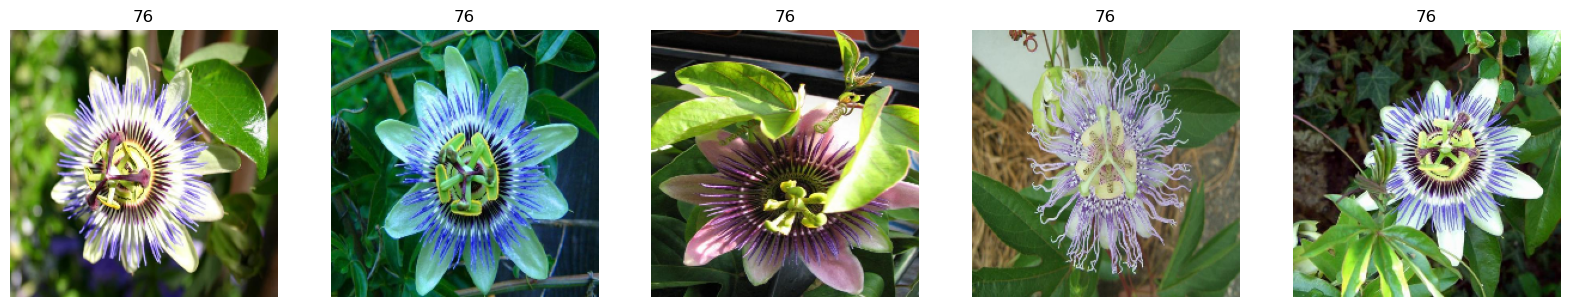

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for i, (image, label) in enumerate(train_ds):
    if i >= 5:
        break
    axes[i].imshow(transforms.ToPILImage(mode='RGB')(image))
    axes[i].set_title(label)
    axes[i].axis("off")

plt.show()

Now we test transfer learning applicatios on the small and large model, and compare them to each other and also to the model trained with random initialization instead of transfer learning.

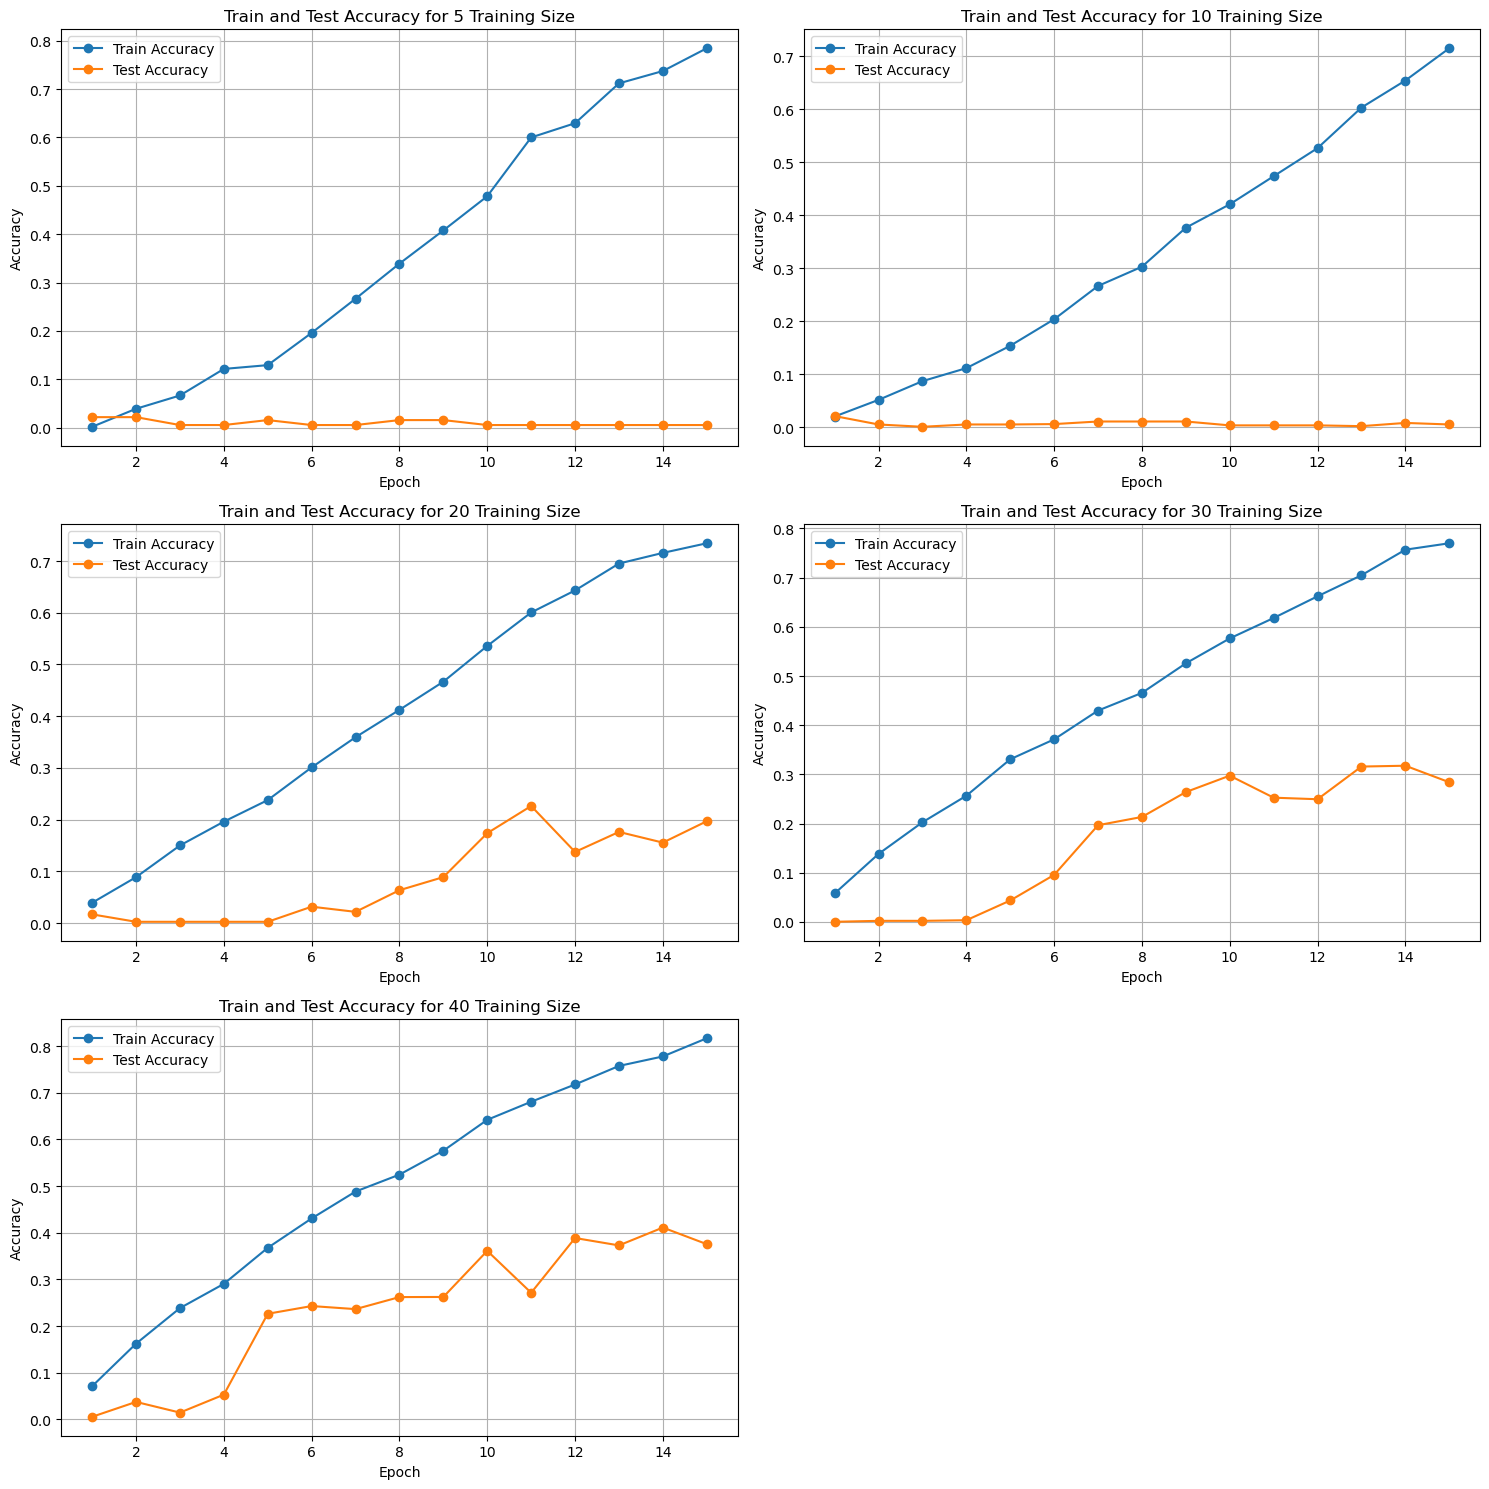

max: 0.4110489170114383 occuring at index: (4, 13)
average: 0.10150401557556585


In [13]:
# test small model performance with random initializatoins
train_size_train_accuracy_blank, train_size_test_accuracy_blank = train_test_sequence(model_name = "small_blank", save_base_name = "models/Oxford/blank_model/")
display_graphs(train_size_train_accuracy_blank, train_size_test_accuracy_blank)

np_array = np.array(train_size_test_accuracy_blank)
max_index = np.unravel_index(np.argmax(np_array), np_array.shape)
mean = np.mean(np_array)
print("max:", max(max(row) for row in train_size_test_accuracy_blank), "occuring at index:", max_index)
print("average:", mean)

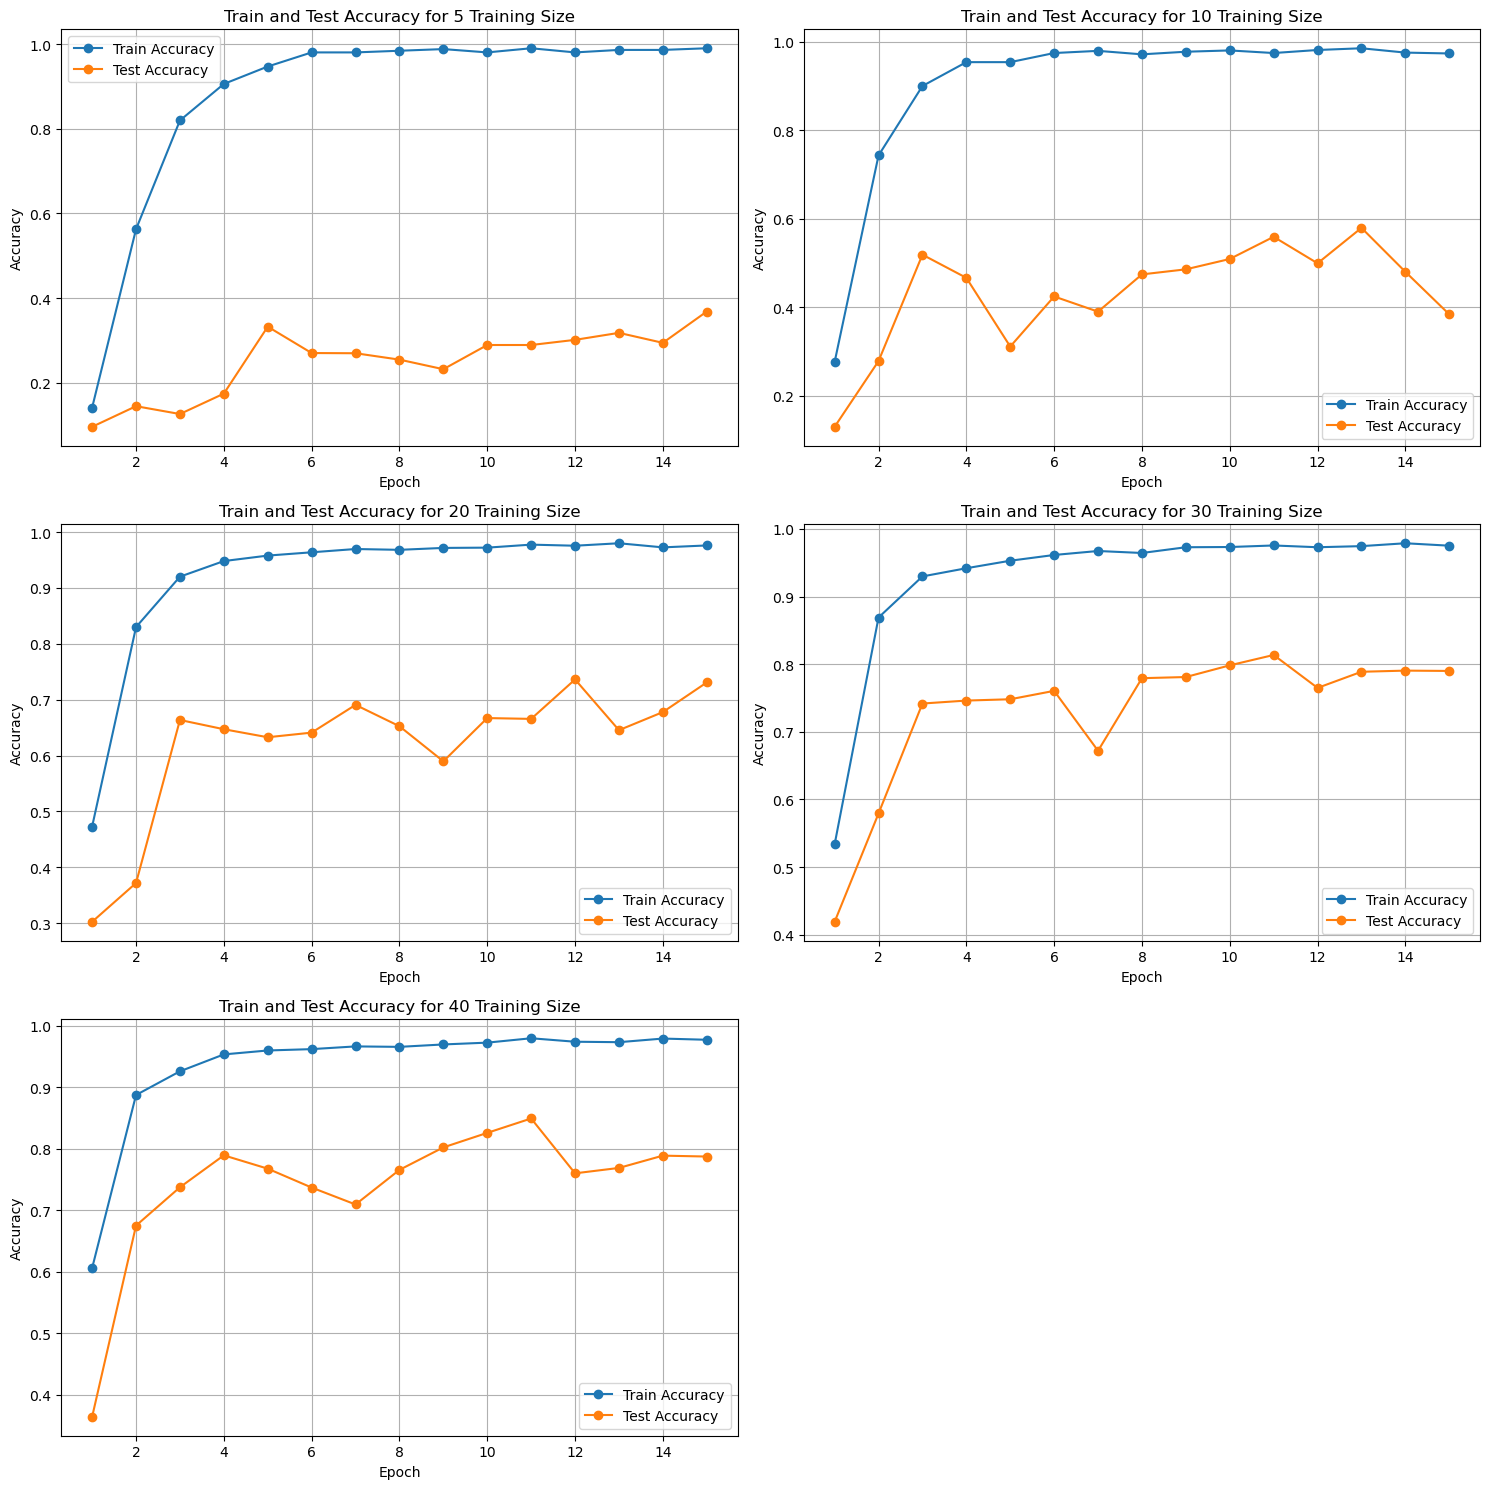

max: 0.8491117060111949 occuring at index: (4, 10)
average: 0.555544739190395


In [15]:
# test small model performance of transfer learning
train_size_train_accuracy_small, train_size_test_accuracy_small = train_test_sequence(model_name = "small", save_base_name = "models/Oxford/small_model/")
display_graphs(train_size_train_accuracy_small, train_size_test_accuracy_small)

np_array = np.array(train_size_test_accuracy_small)
max_index = np.unravel_index(np.argmax(np_array), np_array.shape)
mean = np.mean(np_array)
print("max:", max(max(row) for row in train_size_test_accuracy_small), "occuring at index:", max_index)
print("average:", mean)

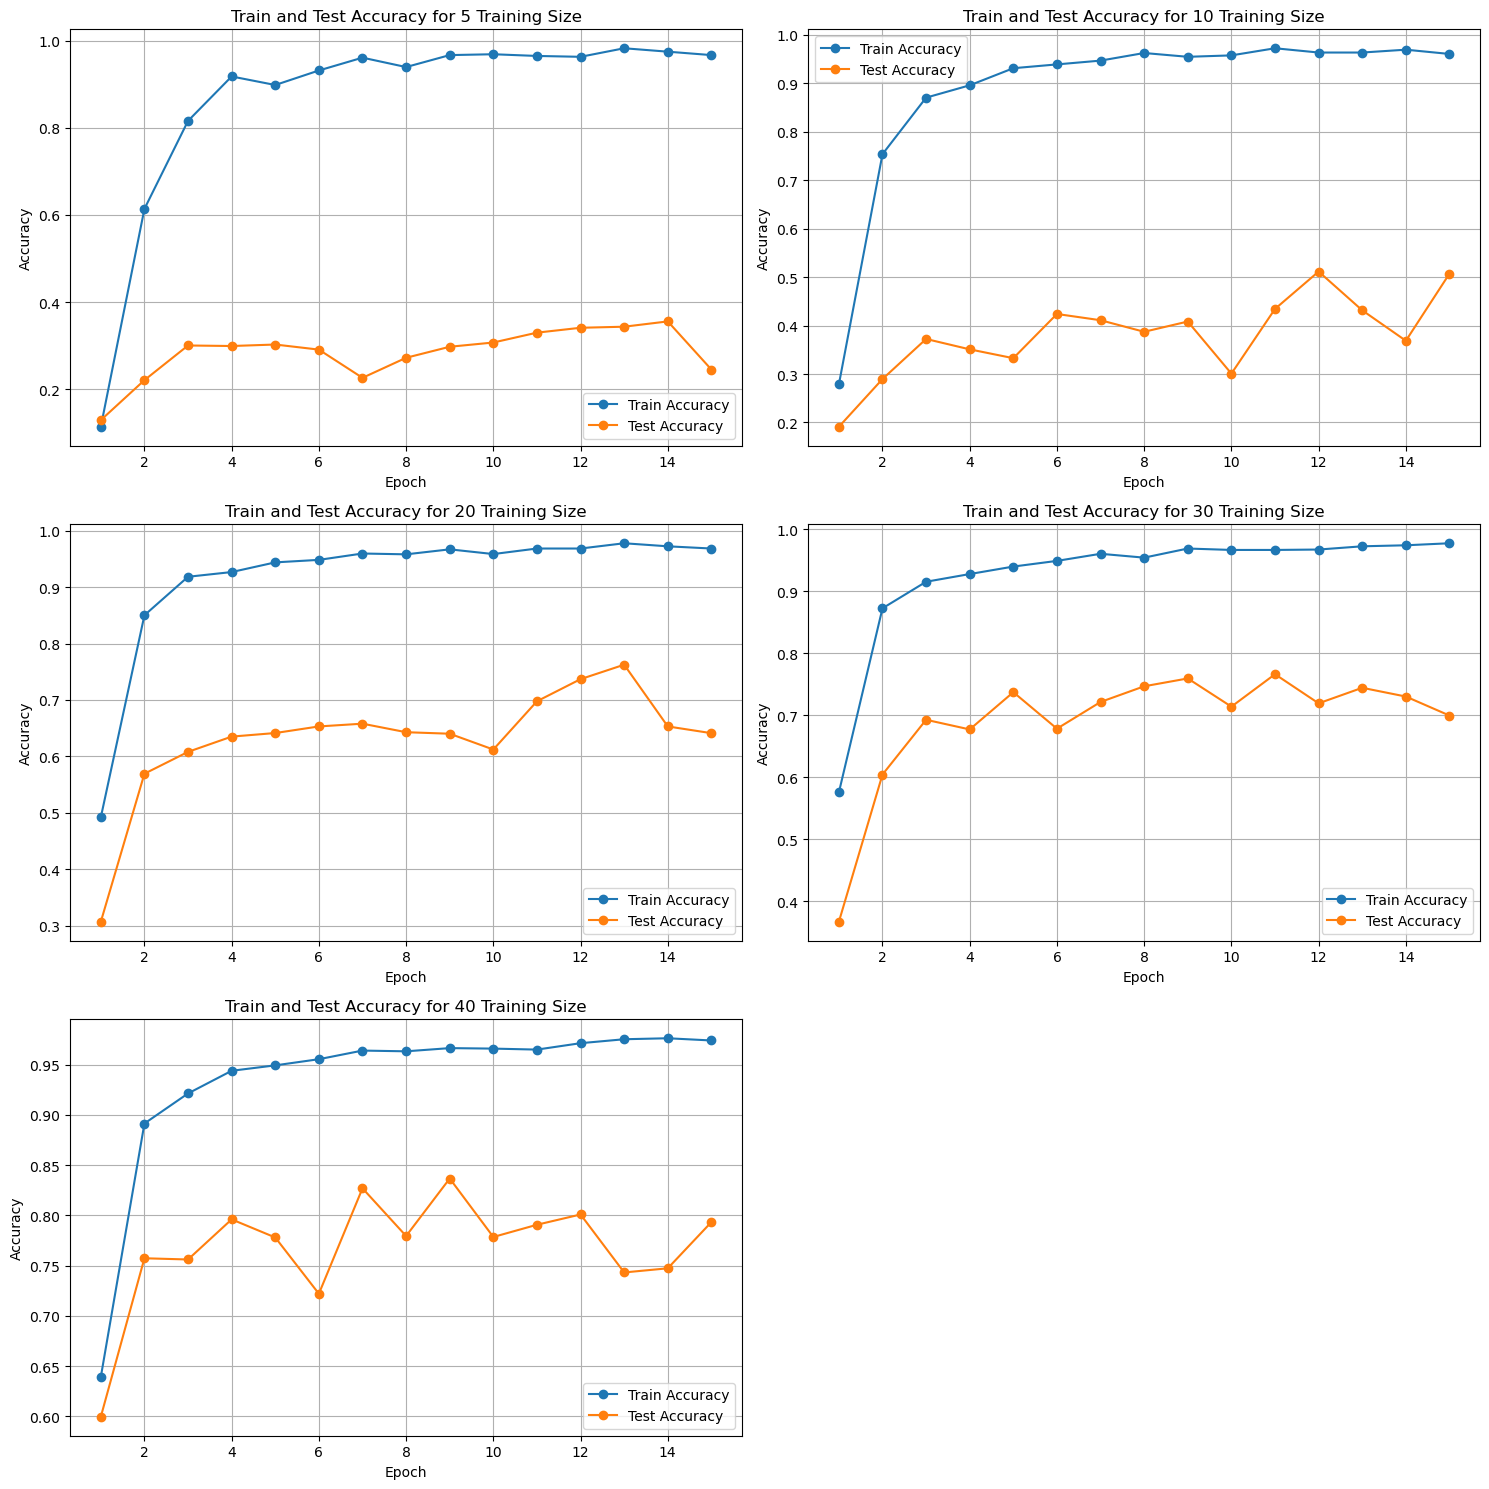

max: 0.8366999269895352 occuring at index: (4, 8)
average: 0.5506773748681756


In [16]:
# test large model performance of transfer learning
train_size_train_accuracy_large, train_size_test_accuracy_large = train_test_sequence(model_name = "large", save_base_name = "models/Oxford/large_model/")
display_graphs(train_size_train_accuracy_large, train_size_test_accuracy_large)

np_array = np.array(train_size_test_accuracy_large)
max_index = np.unravel_index(np.argmax(np_array), np_array.shape)
mean = np.mean(np_array)
print("max:", max(max(row) for row in train_size_test_accuracy_large), "occuring at index:", max_index)
print("average:", mean)

# Conclusion

We see that the small model trained with transfer learning performs best. Both transfer models perform significantly better (over 2x best test accuracy, from 41% to 85% and 5x increase in average accuracy over all epochs and amount of training data, from 10% to 56%) than the randomized model confirming that transfer learning is a very effective way to train a CNN when we have limited training data available, regaurdless of whether its 5 images per class or 40. See the READ_ME_FIRST document for an in depth analysis and conclusion.